In [4]:
import numpy as np

import os
import time
import pickle

import scipy.integrate as integrate
from scipy.optimize import minimize


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})

USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [2]:
def u_x(x, gamma=2.1, A=1.2):
    """
    Utility function for consumption of agent.
    """
    return A*x**(1-gamma) / (1-gamma)


def v_x(x, gamma=2.1):
    """
    Utility function for bequest of agent to offspring.
    """
    return x**(1-gamma) / (1-gamma)

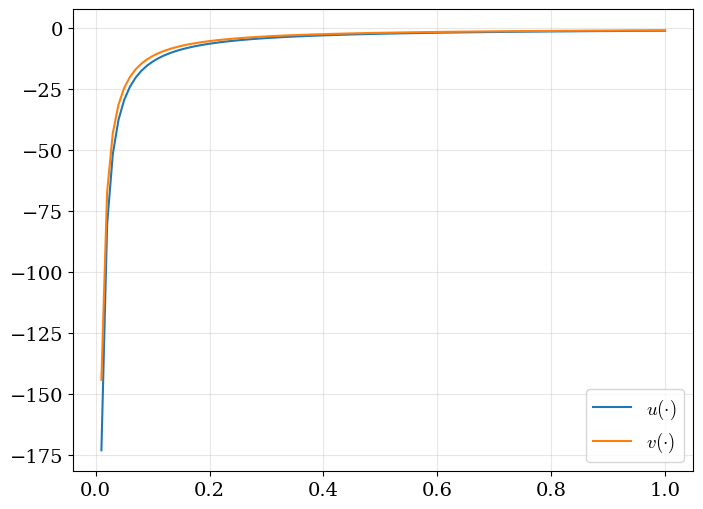

In [5]:
x = np.linspace(0.01, 1, 100)
y1 = u_x(x)
y2 = v_x(x)

plt.plot(x, y1, label=r"$u(\cdot)$")
plt.plot(x, y2, label=r"$v(\cdot)$")

plt.legend()
plt.show()

### Constants

In [6]:
gamma  = 2.1 # utility function parameter
A      = 1.2 # utility function parameter
r0     = 0.5 # left bound for uniform random return on project
r1     = 2.5 # right bound for uniform random return on project
r_hat  = 1.1 # safe return
I      = 1.0 # amount needed to undertake project
e_bar  = 1.5 # amount of entrepreneurial effort needed to undertake project
r_bar  = (1/(r1-r0)) * integrate.quad(lambda x: x, r0, r1)[0] # expected project return

### No project

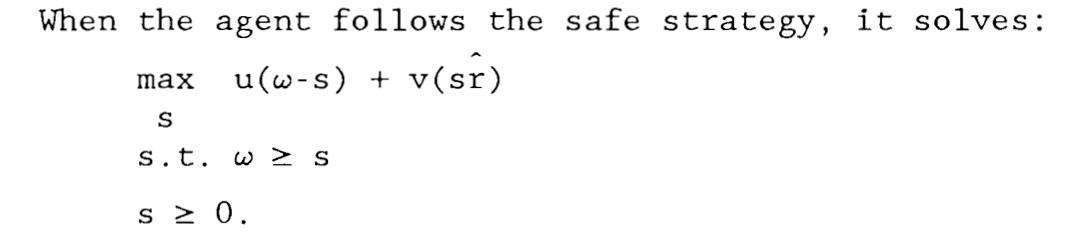

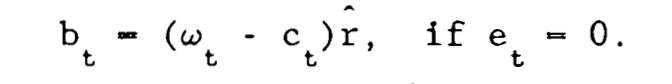

In [7]:
def bequest_safe(w, c):
    """
    Bequest when using safe strategy.
    """
    return (w-c)*r_hat

def consumption_utility(s, w):
    """
    Optimization function for safe investment strategy.
    We seek optimal s value.
    """
    return -(u_x(w-s) + v_x(s*r_hat))

def no_project_best_utility(w):
    """
    Finds optimal s for safe investment strategy.
    Args:
        w: wealth
    Returns:
        optimal utility, optimal s value
    """
    result = minimize(consumption_utility, args=(w), bounds=((0,w),), x0=w/2, method="Powell")
    return -result.fun, result.x[0]

In [8]:
for w in [0.1, 0.5, 0.8, 1.5]:
    util, s = no_project_best_utility(w)
    print(f"w = {w:.1f} | best utility = {util:.4f}\t (s = {s:.3f})")

w = 0.1 | best utility = -51.2537	 (s = 0.047)
w = 0.5 | best utility = -8.7269	 (s = 0.233)
w = 0.8 | best utility = -5.2039	 (s = 0.373)
w = 1.5 | best utility = -2.6063	 (s = 0.699)


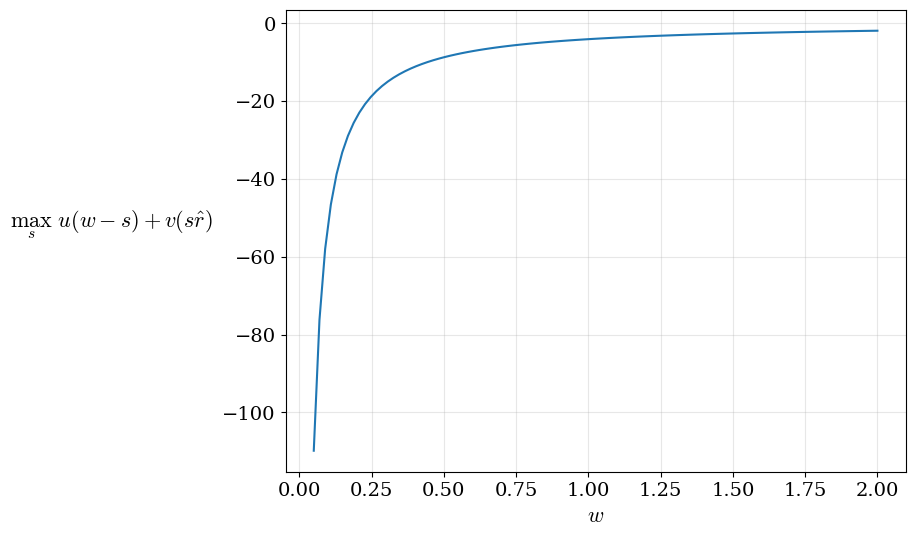

In [9]:
best_util = []
w_vals = np.linspace(0.05, 2, 100)
for w in w_vals:
    best_util.append(no_project_best_utility(w)[0])
plt.plot(w_vals, best_util)
plt.xlabel(r"$w$")
plt.ylabel(r"$\max_{s} \,\, u(w-s)+v(s\hat{r})$", rotation=0, labelpad=80)
plt.show()

# strictly increasing optimum as wealth increases
for i in range(1, len(best_util)):
    assert best_util[i] > best_util[i-1]

### Project

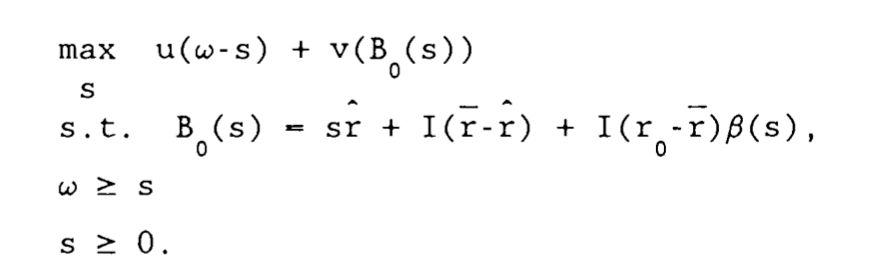

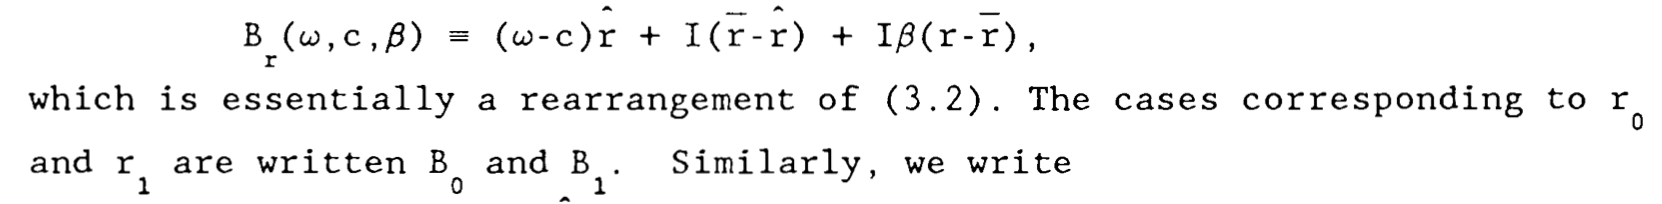

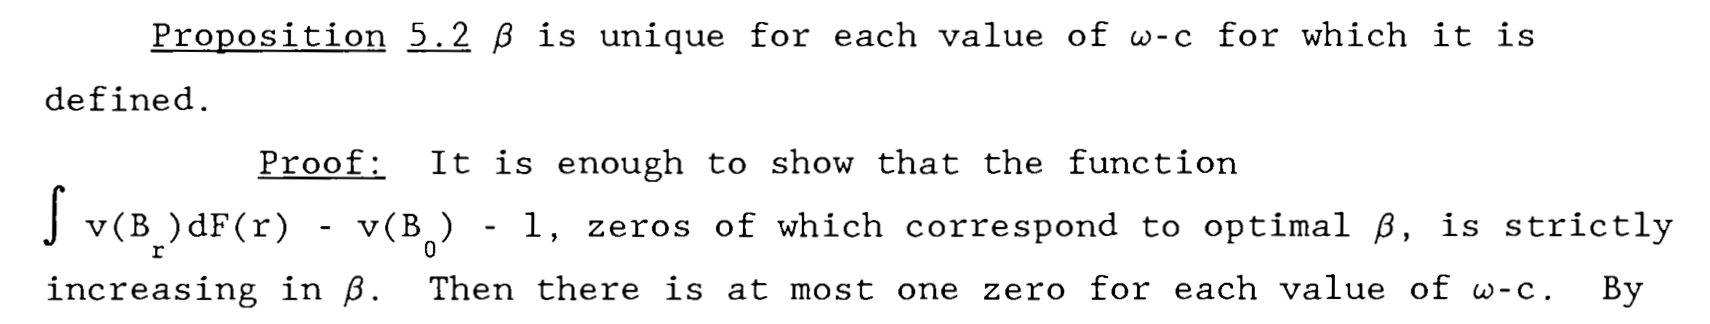

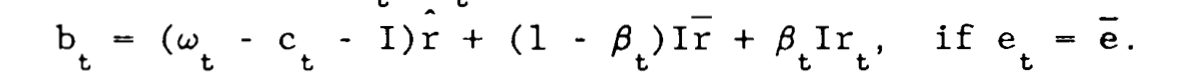

In [93]:
B_r(s, beta, r1)

1.5890488992406535

In [10]:
# NOTE: s := w-c

def bequest_project(s, beta, r):
    return (s - I)*r_hat + (1-beta)*I*r_bar + beta*I*r

def B_r(s, beta, r):
    return s*r_hat + I*(r_bar-r_hat) + I*beta*(r-r_bar)

def B_0(s, beta):
     return s*r_hat + I*(r_bar-r_hat) + I*beta*(r0-r_bar)

def optimal_beta_integral(s, beta):
    return (1/(r1-r0)) * integrate.quad(lambda r : v_x(B_r(s,beta,r)), r0, r1)[0] - v_x(B_0(s,beta)) - 1

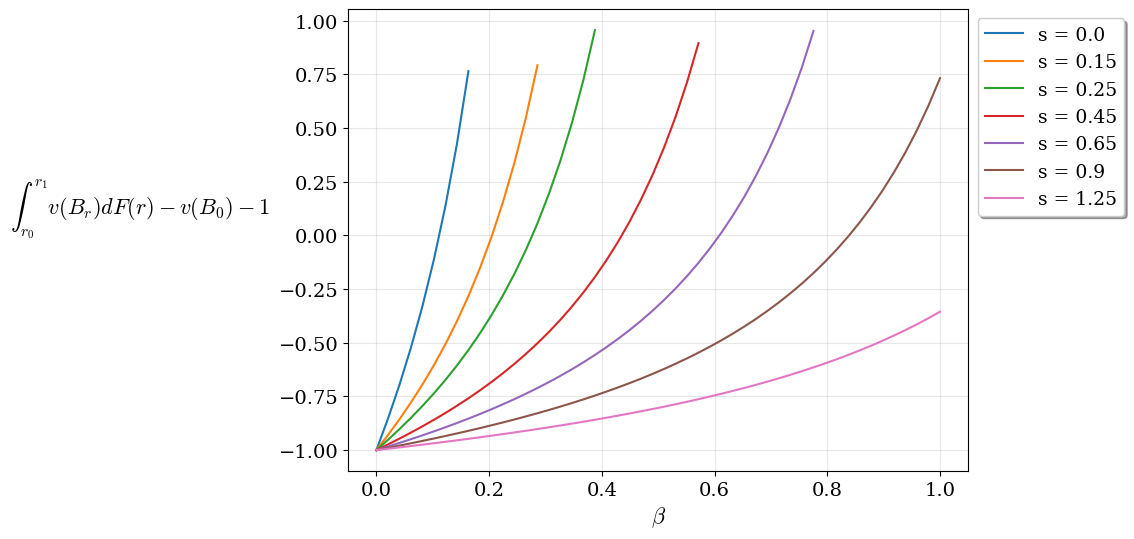

In [11]:
for w in [0.0, 0.3, 0.5, 0.9, 1.3, 1.8, 2.5]:
    s = round(w-(w/2), 2)
    x = []
    vals = []
    beta_vals = np.linspace(0, 1, 50)
    for beta in beta_vals:
        value = optimal_beta_integral(s,beta)
        if not np.isnan(value) and value < 1:
            x.append(beta)
            vals.append(value)
        else:
            break
       
    # strictly increasing, as anticipated
    for i in range(1, len(vals)):
        assert vals[i] > vals[i-1]
        
    plt.plot(x, vals, label=f"s = {s}")

plt.legend(shadow=True, bbox_to_anchor=(1,1))
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\int_{r_0}^{r_1}v(B_r)dF(r) - v(B_0) - 1$", rotation=0, labelpad=100)
plt.show()

In [12]:
def find_optimal_beta(s, lower=0, upper=1, tolerance=1e-9, max_iters=80):
    """
    Binary search to find zero of optimal_beta_integral function.
    """
    iteration = 0
    while True:
        mid = (lower+upper)/2
        try:
            result = optimal_beta_integral(s, mid)
        except:
            upper = 0.5
            continue
        if abs(result) < tolerance:
            break
        if result < 0:
            lower = mid
        elif result > 0:
            upper = mid
        iteration += 1
        if iteration > max_iters:
            return -1
    return mid

def project_optimization(s, w):
    beta = find_optimal_beta(float(s))
    B0 = B_0(s, beta)
    return -(u_x(w-s) + v_x(B0))


def project_best_utility(w):
    """
    Minimize project_optimization by finding optimal s.
    Optimal beta is only defined for s in (0.0, 1.06895), 
    so we set the bounds to (0, min(w, 1.06895)) since s <= w.
    """
    result = minimize(project_optimization, args=(w,), bounds=((0,min(w, 1.06895)),), x0 = w/2)
    s = result.x[0]
    utility = result.fun[0] 
    return -utility, s, find_optimal_beta(float(s))

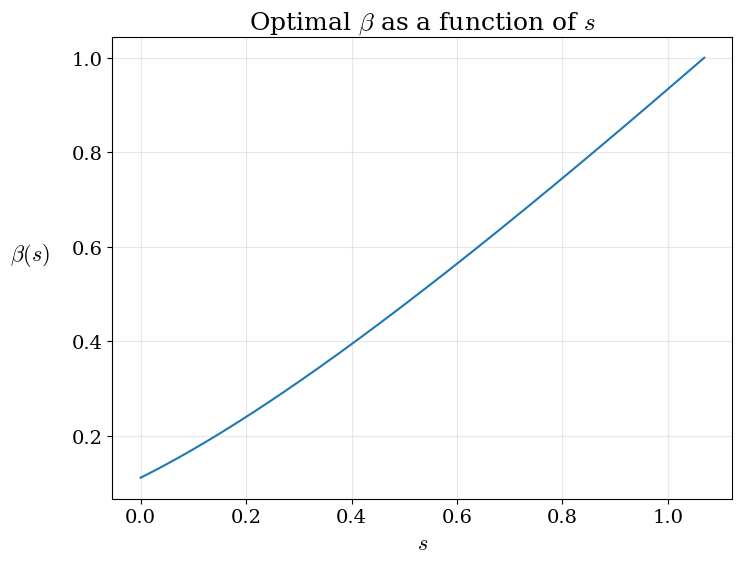

In [13]:
# optimal beta is defined for s in (0.0, 1.06895)
optimal_betas = []
s_vals = np.linspace(0, 1.06895, 1000)
for s in s_vals:
    b = find_optimal_beta(float(s))
    assert b != -1
    optimal_betas.append(b)
    
plt.plot(s_vals, optimal_betas)
plt.title(r"Optimal $\beta$ as a function of $s$")
plt.xlabel(r"$s$")
plt.ylabel(r"$ \beta(s)$", rotation=0, labelpad=30)
plt.show()

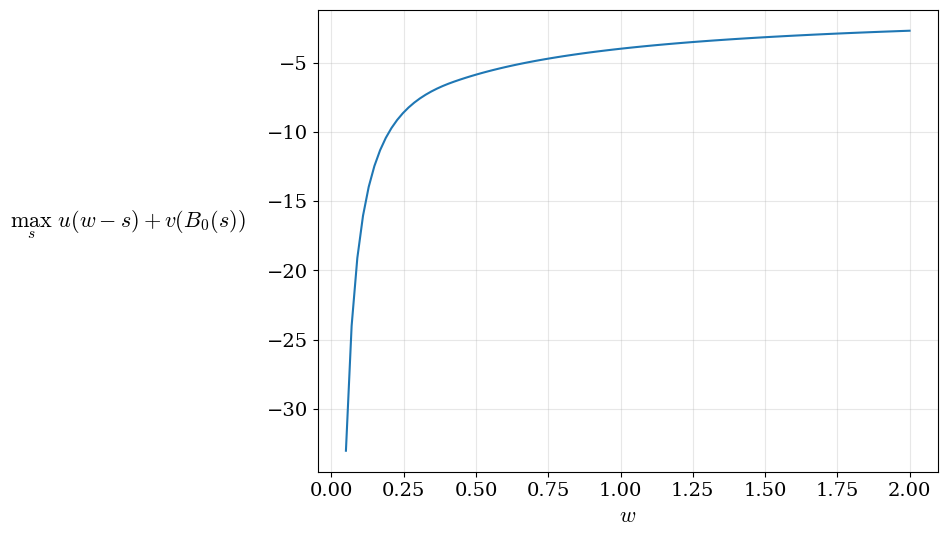

In [14]:
best_util = []
w_vals = np.linspace(0.05, 2, 100)
for w in w_vals:
    best_util.append(project_best_utility(w)[0])
plt.plot(w_vals, best_util)
plt.xlabel(r"$w$")
plt.ylabel(r"$\max_{s} \,\, u(w-s)+v(B_0(s))$", rotation=0, labelpad=100)
plt.show()

# strictly increasing optimum as wealth increases
for i in range(1, len(best_util)):
    assert best_util[i] > best_util[i-1]

## Simulations

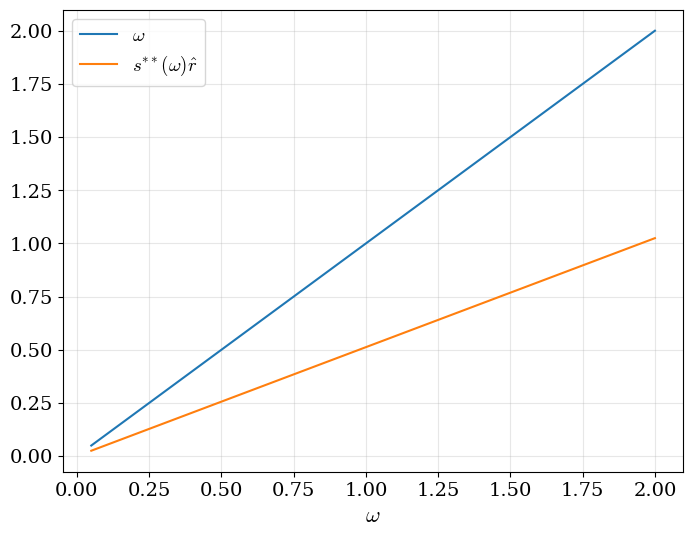

In [69]:
# Proposition 5.5 : for all positive wealth, s**(w).r_hat < w
y1 = []
y2 = []

w_vals = np.linspace(0.05, 2, 500)
for w in w_vals:
    y1.append(w)
    u, s = no_project_best_utility(w)
    assert s * r_hat < w
    y2.append(s * r_hat)
    
plt.plot(w_vals, y1, label=r"$\omega$")
plt.plot(w_vals, y2, label=r"$s^{**}(\omega)\hat{r}$")
plt.xlabel(r"$\omega$")
plt.legend()
plt.show()

In [84]:
# Proposition 5.6 : At initial wealth \hat{B_0}, agent strictly prefers risky strategy

beta_hat = find_optimal_beta(s=0.0)

B_0_hat = I*(r_bar-r_hat) + I*beta_hat*(r0-r_bar)
assert B_0_hat > 0

# Proposition 5.8 : For wealth < B_0_hat, bequest is always larger than initial wealth
asdf = np.random.uniform(r0, r1, size=1000)
for r in range(1000):
    utility_project, s_project, beta = project_best_utility(B_0_hat)
    assert bequest_project(s_project, beta, asdf[r]) > B_0_hat

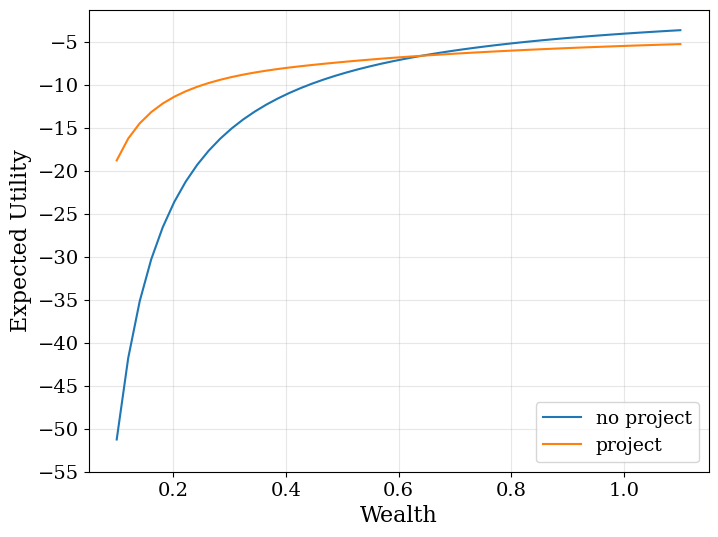

In [43]:
NP = []
P  = []

w_vals = np.linspace(0.1, 1.1, 50)

for wealth in w_vals:

    # project not undertaken
    utility_no_project = no_project_best_utility(wealth)[0]
    NP.append(utility_no_project)

    # project undertaken
    utility_project = project_best_utility(wealth)[0]
    P.append(utility_project)

plt.plot(w_vals, NP, label="no project")
plt.plot(w_vals, [x - e_bar for x in P], label="project")

plt.yticks(np.linspace(-55, -5, 11))
plt.xlabel("Wealth")
plt.ylabel("Expected Utility")

plt.legend()
plt.show()

### Lineage wealth

In [86]:
reps        = 23000
random_vals = np.random.uniform(r0, r1, size=reps)

wealth = 0.1
lineage_wealth = [wealth]

for rep_idx, rep in enumerate(range(reps)):
    if (rep) % (reps / 10) == 0:
        print(rep/reps)

    # safe strategy
    utility_no_project, s_no_project = no_project_best_utility(wealth)

    # risky strategy
    utility_project, s_project, beta = project_best_utility(wealth)
    
    if utility_project - e_bar > utility_no_project:
        # Proposition 5.4
        assert beta <= (r_bar-r_hat)/(r_bar-r0)
        
        # Proposition 5.5 : whenever project is chosen, s*(w).r_hat < w
        assert s_project*r_hat < wealth
        
        wealth = bequest_project(s_project, beta, random_vals[rep_idx])

    else:
        print(f"No project for w = {wealth}")
        c = wealth - s_no_project
        wealth = bequest_safe(wealth, c)
        
    wealth = round(wealth,3)
        
    lineage_wealth.append(wealth)

0.0
0.1
0.2
0.3
No project for w = 0.647
No project for w = 0.648
0.4
No project for w = 0.651
No project for w = 0.646
0.5
0.6
No project for w = 0.646
No project for w = 0.642
No project for w = 0.648
0.7
No project for w = 0.645
0.8
No project for w = 0.648
0.9
No project for w = 0.648
No project for w = 0.653


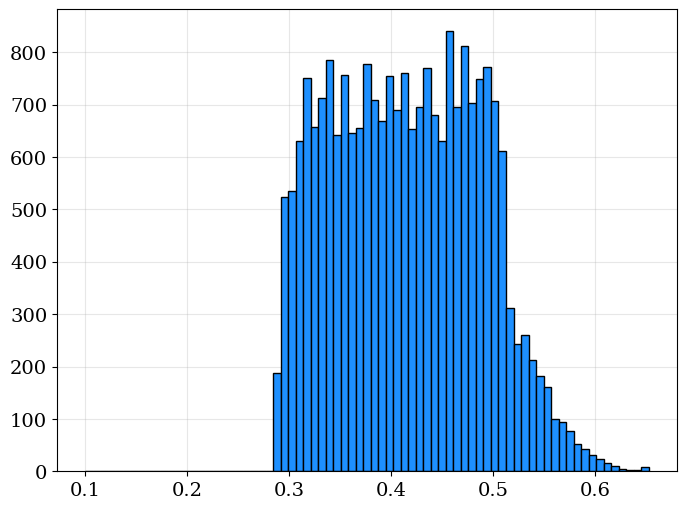

Mean lineage wealth = 0.41


In [87]:
plt.hist(lineage_wealth, bins=75, color="dodgerblue", edgecolor="k")
plt.show()

print(f"Mean lineage wealth = {np.mean(lineage_wealth):.2f}")

### Wealth of multiple lineages

In [113]:
num_lineages = 5000
periods      = 6
random_vals  = np.random.uniform(r0, r1, size=periods*num_lineages)

w_init = 0.1
wealths = {k:w_init for k in range(num_lineages)}
random_idx = 0

for p in range(periods):
    print(p)
    
    for L in range(num_lineages):
        
        # safe strategy
        utility_no_project, s_no_project = no_project_best_utility(wealths[L])

        # risky strategy
        utility_project, s_project, beta = project_best_utility(wealths[L])

        if utility_project - e_bar > utility_no_project:
            # Proposition 5.4
            assert beta <= (r_bar-r_hat)/(r_bar-r0)
            # Proposition 5.5 : whenever project is chosen, s*(w).r_hat < w
            assert s_project*r_hat < wealths[L]
            wealths[L] = bequest_project(s_project, beta, random_vals[random_idx])
            random_idx += 1
        else:
            print(f"No project for w = {wealths[L]}")
            c = wealths[L] - s_no_project
            wealths[L] = bequest_safe(wealths[L], c)

0
1
2
3
4
5
No project for w = 0.646542061267005
No project for w = 0.662679534640939
No project for w = 0.6456503877238957


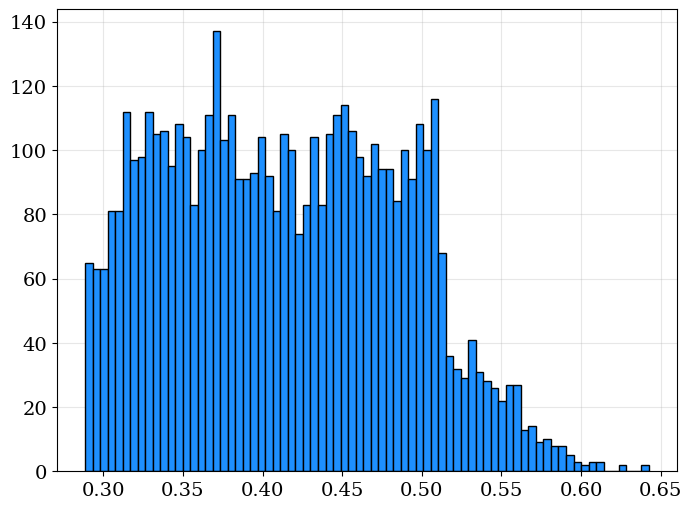

Mean wealth = 0.41


In [115]:
plt.hist(wealths.values(), bins=75, color="dodgerblue", edgecolor="k")
plt.show()

print(f"Mean wealth = {np.mean(list(wealths.values())):.2f}")

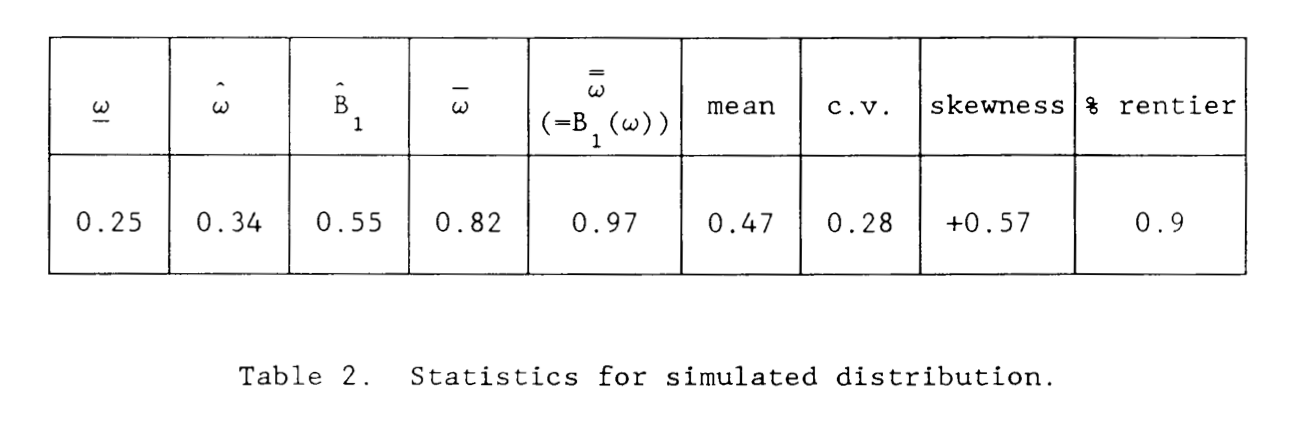

In [117]:
min(wealths.values())

0.28848670755375105

In [122]:
B_1_hat = I*(r_bar-r_hat) + I*beta_hat*(r1-r_bar)
B_1_hat

0.5115866637555881

- $\underline{w}$ : wealth below which bequest is always larger than initial wealth (equal to $\hat{B}_0$)
    - for me: $\underline{w} \approx 0.28$
    

- $\bar{w}$ : agent takes project if $w < \bar{w}$ and does not if $w > \bar{w}$
    - for me: $\bar{w} \approx 0.61$
    
    
- $\hat{B}_1 = I(\bar{r}-\hat{r}) + I\hat{\beta}(r_1-\bar{r})$, where $\hat{\beta}=\beta(s=0)$ is the equity share retained by an agent that saves zero
    - for me: $\hat{B}_1 \approx 0.511$
    
    
- mean $= 0.41$ for me